In [1]:
import pandas as pd
import seaborn as sns

## Parse output

In [2]:
approach = list()
num_vertices = list()
num_threads = list()
time_spent = list()

In [3]:
def get_iter_params(line: str):
    a = line.split()
    approach.append(a[1])
    num_vertices.append(a[2])
    if len(a) == 4:
        num_threads.append('1')
    else:
        num_threads.append(a[3])


def get_bfs_time_spent(line: str):
    a = line.split()
    time_spent.append(a[-1])

In [4]:
with open("../bin/output.txt", "r") as f:
    line = f.readline()
    while line:
        if line.startswith("#"):
            get_iter_params(line)
        elif line.startswith("BFS time"):
            get_bfs_time_spent(line)
        line = f.readline()

## To pandas dataframe

In [5]:
df = pd.DataFrame({
    'approach': approach,
    'num_vertices': num_vertices,
    'num_threads': num_threads,
    'time_spent': time_spent
})
df.loc[:, 'num_vertices'] = pd.to_numeric(df['num_vertices'])
df.loc[:, 'num_threads'] = pd.to_numeric(df['num_threads'])
df.loc[:, 'time_spent'] = pd.to_numeric(df['time_spent'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63 entries, 0 to 62
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   approach      63 non-null     object 
 1   num_vertices  63 non-null     int64  
 2   num_threads   63 non-null     int64  
 3   time_spent    63 non-null     float64
dtypes: float64(1), int64(2), object(1)
memory usage: 2.1+ KB


In [6]:
# aggregation
df = df.groupby(list(df.columns[:-1]))['time_spent'].mean().reset_index()

# to categorical
df.loc[:, 'size'] = pd.cut(df['num_vertices'], 
                           bins=[0, 12500, 25000, 50000],
                           labels=['Half Size', 'Original', 'Double Size'])
df = df.rename({'time_spent': 'average_time_spent'},
               axis=1)
df

,approach,num_vertices,num_threads,average_time_spent,size
0,parallel,12500,2,0.163126,Half Size
1,parallel,12500,4,0.093561,Half Size
2,parallel,12500,6,0.069842,Half Size
3,parallel,12500,8,0.071498,Half Size
4,parallel,12500,10,0.062467,Half Size
5,parallel,12500,12,0.056977,Half Size
6,parallel,25000,2,0.627538,Original
7,parallel,25000,4,0.340943,Original
8,parallel,25000,6,0.241404,Original
9,parallel,25000,8,0.252117,Original


## Analysis

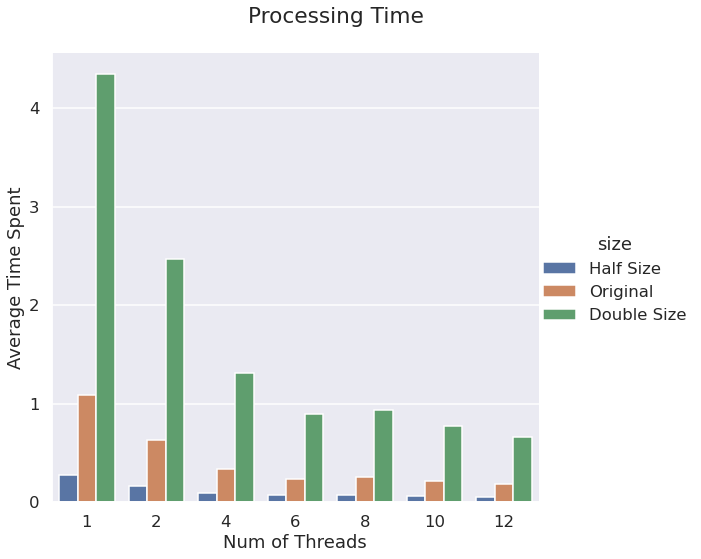

In [7]:
# Processing time
sns.set(rc={'figure.facecolor':'white'})
sns.set_context("talk")
g = sns.catplot(
    data=df,
    kind='bar', 
    x='num_threads',
    y='average_time_spent',
    hue='size',
    height=8
)
# sns.move_legend(g, "center right", bbox_to_anchor=(.85, .65))
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Processing Time')
g.set_axis_labels("Num of Threads", "Average Time Spent")
g.savefig("../plots/times.png")

In [8]:
# speedup, efficiency
sequential_times = df.loc[df['approach'] == 'sequential', ['size', 'average_time_spent']].to_dict()
sequential_times = {k:v for k,v in zip(sequential_times['size'].values(),
                                       sequential_times['average_time_spent'].values())}
df = df[df['approach'] != 'sequential']
df = df.rename({'average_time_spent': 'parallel_average_time_spent'},
               axis=1)
df.loc[:, 'sequential_average_time_spent'] = df.apply(lambda x: sequential_times[x['size']],
                                              axis=1)
df.loc[:, 'speedup'] = df['sequential_average_time_spent'] / df['parallel_average_time_spent']
df.loc[:, 'efficiency'] = df['speedup'] / df['num_threads']
df.sort_values(by=['size', 'num_threads'])

,approach,num_vertices,num_threads,parallel_average_time_spent,size,sequential_average_time_spent,speedup,efficiency
0,parallel,12500,2,0.163126,Half Size,0.273576,1.677081,0.838540
1,parallel,12500,4,0.093561,Half Size,0.273576,2.924039,0.731010
2,parallel,12500,6,0.069842,Half Size,0.273576,3.917051,0.652842
3,parallel,12500,8,0.071498,Half Size,0.273576,3.826345,0.478293
4,parallel,12500,10,0.062467,Half Size,0.273576,4.379528,0.437953
5,parallel,12500,12,0.056977,Half Size,0.273576,4.801516,0.400126
6,parallel,25000,2,0.627538,Original,1.089176,1.735633,0.867816
7,parallel,25000,4,0.340943,Original,1.089176,3.194594,0.798649
8,parallel,25000,6,0.241404,Original,1.089176,4.511838,0.751973
9,parallel,25000,8,0.252117,Original,1.089176,4.320114,0.540014


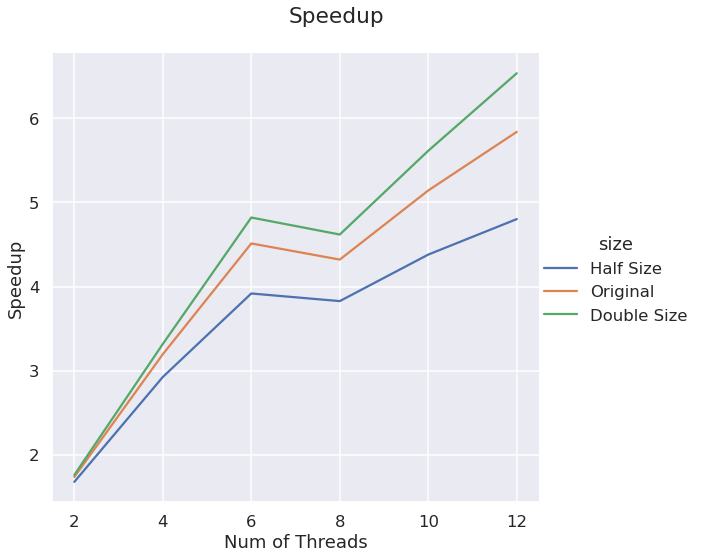

In [9]:
sns.set(rc={'figure.facecolor':'white'})
sns.set_context("talk")
g = sns.relplot(
    data=df,
    kind='line', 
    x='num_threads',
    y='speedup',
    hue='size',
    height=8
)
# sns.move_legend(g, "center right", bbox_to_anchor=(.85, .65))
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Speedup')
g.set_axis_labels("Num of Threads", "Speedup")
g.savefig("../plots/speedup.png")

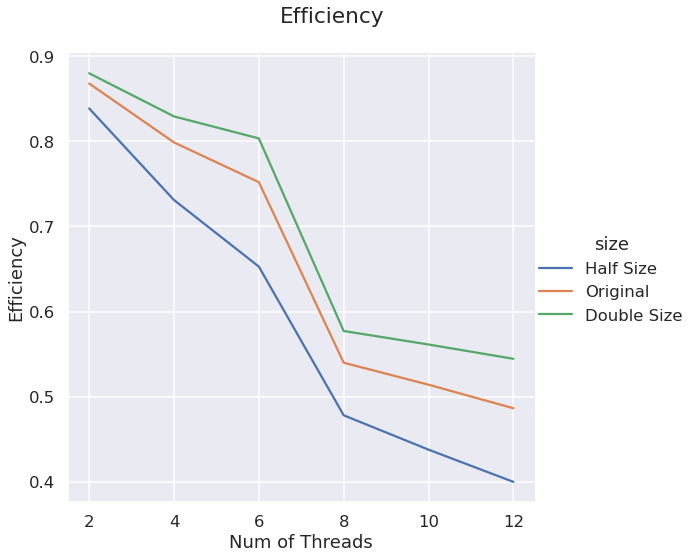

In [10]:
sns.set(rc={'figure.facecolor':'white'})
sns.set_context("talk")
g = sns.relplot(
    data=df,
    kind='line', 
    x='num_threads',
    y='efficiency',
    hue='size',
    height=8
)
# sns.move_legend(g, "center right", bbox_to_anchor=(.85, .65))
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Efficiency')
g.set_axis_labels("Num of Threads", "Efficiency")
g.savefig("../plots/efficiency.png")